# Sailing Challenge: Understanding the Environment

Welcome to the Sailing Challenge! In this walkthrough notebook, we'll explore the sailing environment in depth to build your understanding of the physics, dynamics, and challenges you'll face when developing your sailing agent.

This notebook is designed to be pedagogical and comprehensive, helping you understand:

1. **Environment Basics**: The structure of the sailing world, goals, and observations
2. **Sailing Physics**: How real-world sailing principles are implemented
3. **Wind Patterns**: How wind varies and affects navigation
4. **Control Mechanics**: How actions translate to boat movement
5. **Observation and State Space**: What information your agent receives
6. **Reward Structure**: How success is measured

By the end of this notebook, you'll have the knowledge needed to start developing your own sailing agent.

## 1. Setup and Imports

First, let's import all the necessary modules. Our environment uses standard scientific Python libraries along with custom modules for the sailing environment.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the environment and evaluation modules
from env_sailing import SailingEnv
from evaluation import evaluate_agent, visualize_trajectory
from sailing_physics import (
    generate_velocity_polar_plot, 
    generate_efficiency_curve,
    show_tacking_maneuver  # Add this import
)

# Import scenarios
from wind_scenarios import get_wind_scenario, WIND_SCENARIOS

## 2. Environment Overview

The sailing environment simulates a boat navigating from a starting point to a goal while being affected by wind. This is a challenging control problem because:

1. The boat can't move directly against the wind (upwind sailing requires strategic navigation)
2. Wind conditions change over time and vary across the space
3. Boat physics include momentum and sailing efficiency based on wind angle
4. Optimal routes are rarely straight lines to the goal

Let's start by creating a basic environment and visualizing it:

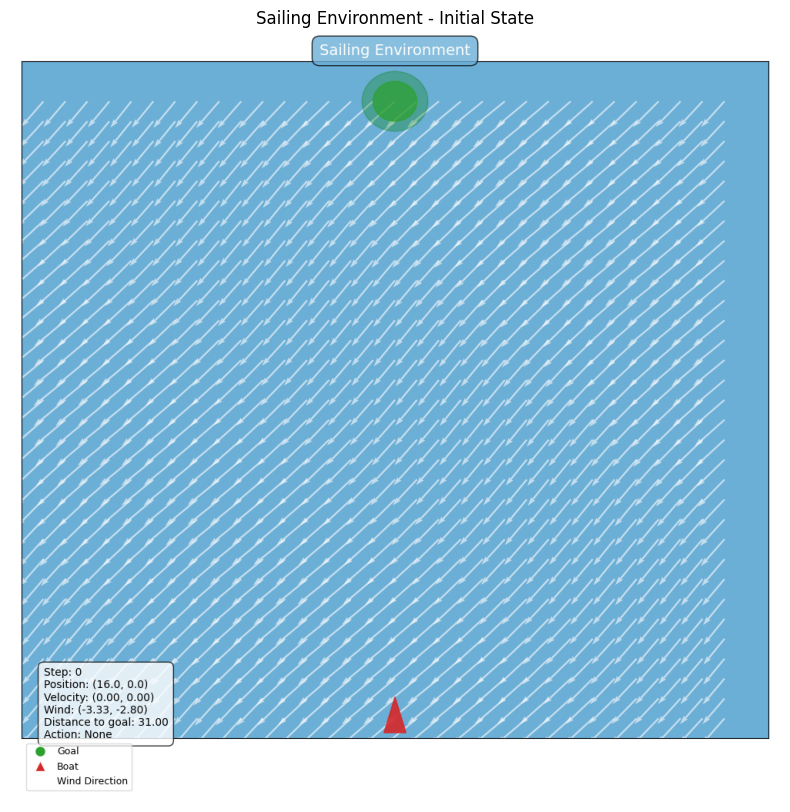

Environment Information:
Grid Size: (32, 32)
Starting Position: [16  0]
Goal Position: [16 31]
Initial Wind at Boat: [-3.32917761 -2.80499559]


In [2]:
# Create a basic sailing environment
env = SailingEnv(
    grid_size=(32, 32),  # 32x32 grid world
    wind_grid_density=25,  # How many wind arrows to display
    wind_arrow_scale=80,  # Scale factor for arrow visualization
    render_mode="rgb_array"  # Generate images for visualization
)

# Reset the environment to initialize
observation, info = env.reset(seed=42)  # Fixed seed for reproducibility

# Render the environment
plt.figure(figsize=(10, 10))
plt.imshow(env.render())
plt.axis('off')
plt.title('Sailing Environment - Initial State')
plt.show()

# Describe the environment
print("Environment Information:")
print(f"Grid Size: {env.grid_size}")
print(f"Starting Position: {info['position']}")
print(f"Goal Position: {env.goal_position}")
print(f"Initial Wind at Boat: {info['wind']}")

### Understanding the Visualization

In the visualization above:

- **Boat**: The triangular shape represents your sailing boat. The pointed end indicates the direction.
- **Wind Arrows**: The blue arrows show wind direction and strength at different points in the grid.
- **Goal**: The red circle at the top center is your destination.
- **Grid**: The background represents the sailing area (think of it as a lake or sea).

The challenge is to navigate the boat from the starting position (bottom) to the goal (top) by choosing appropriate sailing directions that account for the wind.

### Wind Scenarios

The wind field you can see in the previous rendering is generated based on parameters defined during environment creation. In the real challenge, you'll encounter several different initial wind fields:

1. **Training Wind Scenarios**: These are provided for you to develop and test your agent:
   - **Training Wind Scenario 1**: Features north-northwest wind patterns
   - **Training Wind Scenario 2**: Features south-southwest wind patterns
   - **Training Wind Scenario 3**: Features north-northeast wind patterns

2. **Test Wind Scenario**: A hidden wind scenario used for final evaluation (not accessible during development)

Each wind scenario has unique characteristics in terms of:
- Base wind direction and strength
- Spatial wind patterns across the grid
- Pattern scales and strength variations

BUT they all *evolve over time according to the same underlying dynamics* (i.e. they obbey to the same underlying Markov Decision Process). This means that regardless of which wind scenario you're dealing with, the wind will follow similar evolution rules (perturbation amplitude, rotation rates, etc.) as time progresses within an episode. Think of the wind scenarios as different starting points, but with consistent physics governing how they change.

The predefined wind scenarios are available in the `wind_scenarios` module and can be loaded using the `get_wind_scenario()` function. We'll explore these different wind scenarios later in this notebook to understand how your agent will need to adapt to different wind conditions.

Let's continue exploring the environment basics before diving into different wind scenarios.

## 3. Sailing Physics: How Wind Affects Movement

Sailing involves a fascinating interplay of physics. Unlike motorboats that can go in any direction, sailboats are constrained by their relation to the wind. Let's explore how sailing efficiency varies depending on the angle to the wind:

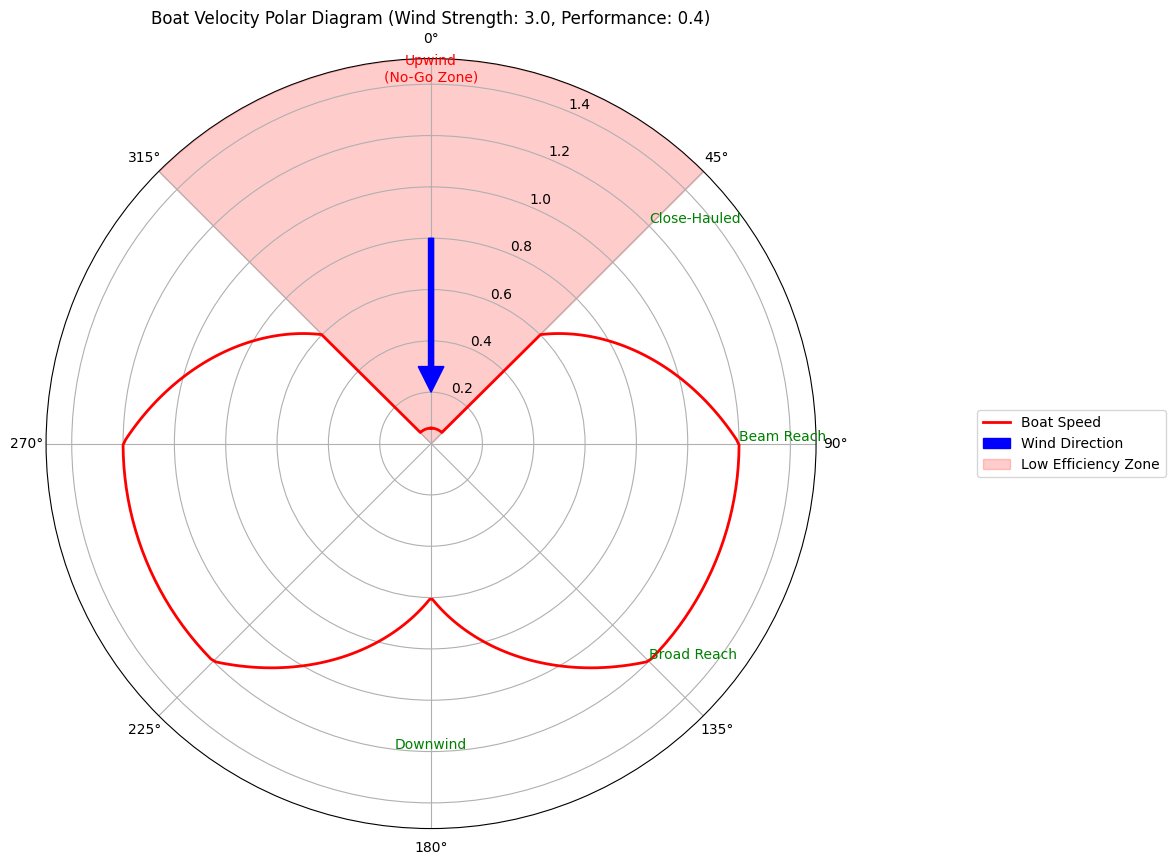

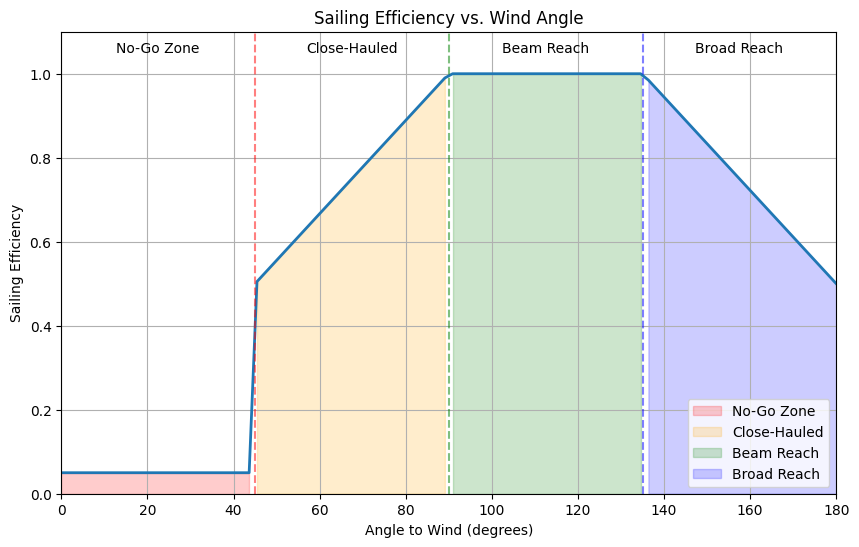

Key Sailing Concepts:
1. No-Go Zone: You cannot sail directly into the wind (within ~45° of upwind)
2. Close-hauled: Sailing at ~45° to the wind - relatively efficient but not optimal
3. Beam Reach: Sailing perpendicular to the wind - typically the fastest point of sail
4. Broad Reach: Wind coming from behind at an angle - also very efficient
5. Running: Wind directly behind - surprisingly not the fastest due to aerodynamics


In [3]:
# Create a polar plot showing sailing efficiency by angle
polar_fig = generate_velocity_polar_plot(wind_strength=3.0, boat_performance=0.4)
plt.show()

# Create an efficiency curve
eff_fig = generate_efficiency_curve()
plt.show()

print("Key Sailing Concepts:")
print("1. No-Go Zone: You cannot sail directly into the wind (within ~45° of upwind)")
print("2. Close-hauled: Sailing at ~45° to the wind - relatively efficient but not optimal")
print("3. Beam Reach: Sailing perpendicular to the wind - typically the fastest point of sail")
print("4. Broad Reach: Wind coming from behind at an angle - also very efficient")
print("5. Running: Wind directly behind - surprisingly not the fastest due to aerodynamics")

## 4. Actions and Control Mechanics

In the sailing environment, your agent needs to choose from a discrete set of actions to navigate the boat. Let's understand the action space and how it affects the boat's movement.

### Action Space

There are 9 possible actions your agent can take:
- Actions 0-7: Move in one of 8 directions (like compass points)
- Action 8: Stay in place

These actions represent the direction you want the boat to move, but the actual movement will be influenced by:
- Wind direction and strength
- Sailing efficiency at that angle to the wind
- Current velocity (momentum)
- Physical constraints of sailing

Let's see how these actions correspond to directions:

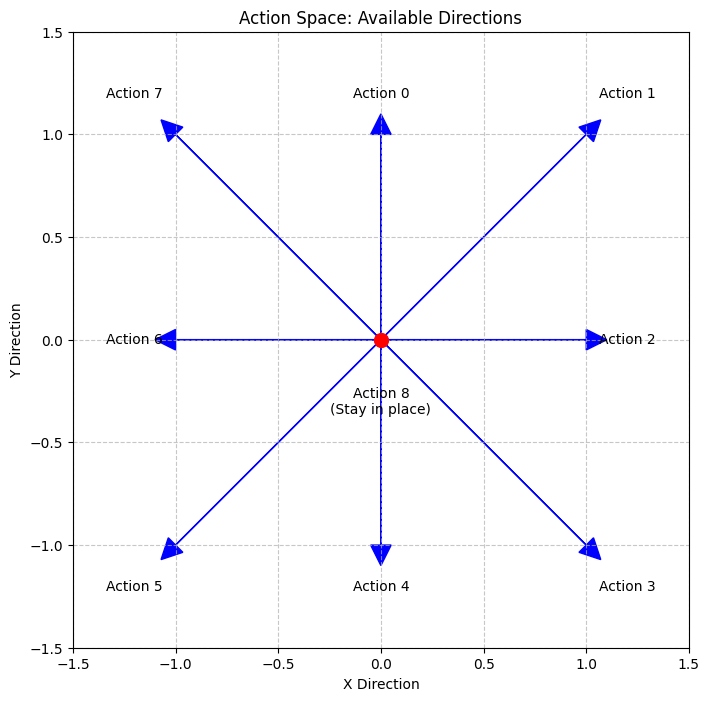

Important Note: The actual movement resulting from each action will depend on wind conditions!
- Trying to move directly upwind (against the wind) will result in minimal progress
- Moving perpendicular to the wind (beam reach) will be most efficient
- Your agent needs to learn which actions are effective in different wind conditions


In [4]:
# Define the action space
actions = [
    (0, 1),    # 0: North
    (1, 1),    # 1: Northeast
    (1, 0),    # 2: East
    (1, -1),   # 3: Southeast
    (0, -1),   # 4: South
    (-1, -1),  # 5: Southwest
    (-1, 0),   # 6: West
    (-1, 1),   # 7: Northwest
    (0, 0)     # 8: Stay in place
]

# Create a visual representation of the action space
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Draw arrows for each direction
for i, (dx, dy) in enumerate(actions[:8]):  # Skip the "stay in place" action
    ax.arrow(0, 0, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    ax.text(dx*1.2, dy*1.2, f"Action {i}", ha='center', va='center')

# Mark the center for "stay in place"
ax.plot(0, 0, 'ro', markersize=10)
ax.text(0, -0.3, "Action 8\n(Stay in place)", ha='center', va='center')

# Add grid, title and labels
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Action Space: Available Directions')
ax.set_xlabel('X Direction')
ax.set_ylabel('Y Direction')
ax.set_aspect('equal')
plt.show()

print("Important Note: The actual movement resulting from each action will depend on wind conditions!")
print("- Trying to move directly upwind (against the wind) will result in minimal progress")
print("- Moving perpendicular to the wind (beam reach) will be most efficient")
print("- Your agent needs to learn which actions are effective in different wind conditions")

## 5. Observation and State Space

Your agent will make decisions based on observations from the environment. Let's understand what information is available to your agent at each step.

### Observation Structure

The observation is now an extended vector containing:
- `x, y`: Current position (indices 0, 1)
- `vx, vy`: Current velocity (indices 2, 3)
- `wx, wy`: Current wind vector at the boat's position (indices 4, 5)
- **Full Wind Field**: The complete wind field flattened into a 1D array (indices 6 onward)

The full wind field provides your agent with "weather information" - knowledge about wind conditions across the entire environment. This is a powerful feature that allows your agent to plan routes strategically, similar to how real sailors use weather forecasts.

Let's examine a sample observation:

Observation shape: (2054,)

Observation breakdown:
Position (x, y): (16.0, 0.0)
Velocity (vx, vy): (0.000, 0.000)
Wind at position (wx, wy): (-3.329, -2.805)

Wind field information:
Grid size: (32, 32)
Flattened wind field size: 2048
Wind field in observation: indices 6 to 2053

Sample of wind field data (first 10 points):
Grid point 0: Wind (wx, wy) = (-2.344, -2.733)
Grid point 1: Wind (wx, wy) = (-2.308, -2.770)
Grid point 2: Wind (wx, wy) = (-2.312, -2.765)
Grid point 3: Wind (wx, wy) = (-2.260, -2.799)
Grid point 4: Wind (wx, wy) = (-2.283, -2.811)
Grid point 5: Wind (wx, wy) = (-2.314, -2.825)
Grid point 6: Wind (wx, wy) = (-2.399, -2.858)
Grid point 7: Wind (wx, wy) = (-2.454, -2.858)
Grid point 8: Wind (wx, wy) = (-2.546, -2.898)
Grid point 9: Wind (wx, wy) = (-2.620, -2.896)


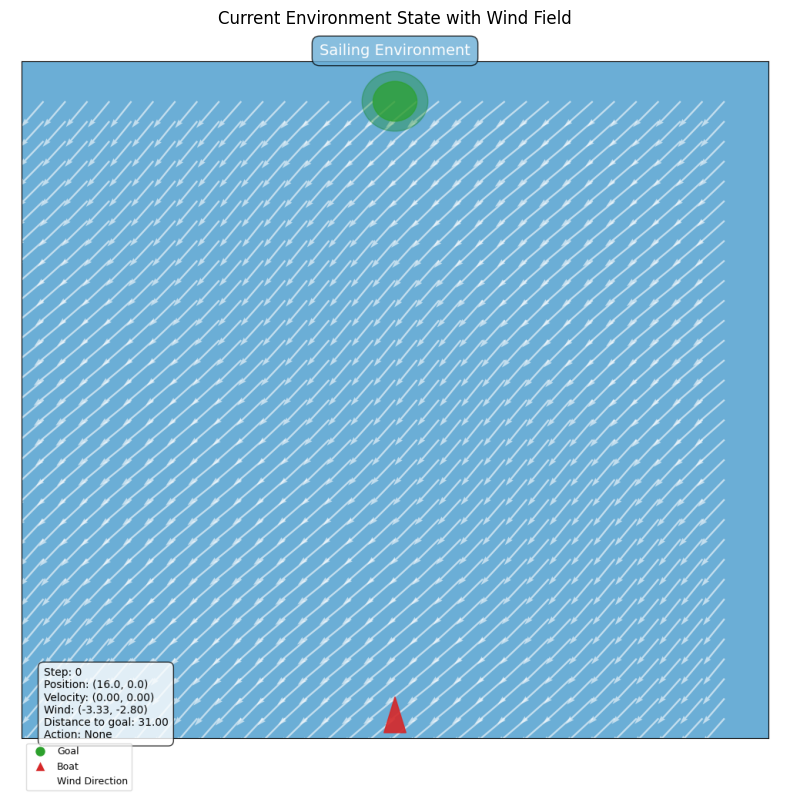


Strategy Tip: Your agent should consider:
1. Where am I relative to the goal?
2. What is my current momentum?
3. What is the wind direction and strength at my current position?
4. How does the wind field look across the environment? Where are favorable wind conditions?
5. Can I plan a route that takes advantage of favorable wind patterns?


In [5]:
# Reset the environment
observation, info = env.reset(seed=42)

# Display the observation structure
print(f"Observation shape: {observation.shape}")
print("\nObservation breakdown:")
print(f"Position (x, y): ({observation[0]:.1f}, {observation[1]:.1f})")
print(f"Velocity (vx, vy): ({observation[2]:.3f}, {observation[3]:.3f})")
print(f"Wind at position (wx, wy): ({observation[4]:.3f}, {observation[5]:.3f})")

# Calculate grid size from the wind field size
grid_size = env.grid_size
wind_field_size = grid_size[0] * grid_size[1] * 2  # x*y grid with 2 components per point
print(f"\nWind field information:")
print(f"Grid size: {grid_size}")
print(f"Flattened wind field size: {wind_field_size}")
print(f"Wind field in observation: indices 6 to {6+wind_field_size-1}")

# Display a small part of the wind field from the observation
print("\nSample of wind field data (first 10 points):")
wind_data = observation[6:26]  # Show first 10 points (each with x,y components)
for i in range(0, len(wind_data), 2):
    print(f"Grid point {i//2}: Wind (wx, wy) = ({wind_data[i]:.3f}, {wind_data[i+1]:.3f})")

# Visualize the current state
plt.figure(figsize=(10, 10))
plt.imshow(env.render())
plt.axis('off')
plt.title('Current Environment State with Wind Field')
plt.show()

print("\nStrategy Tip: Your agent should consider:")
print("1. Where am I relative to the goal?")
print("2. What is my current momentum?")
print("3. What is the wind direction and strength at my current position?")
print("4. How does the wind field look across the environment? Where are favorable wind conditions?")
print("5. Can I plan a route that takes advantage of favorable wind patterns?")

### Visualizing Environment State from Observations

The `SailingEnv.visualize_observation()` function allows you to create a complete visualization of the environment from any observation. This is particularly useful for:

1. **Understanding the current state** of the sailing environment
2. **Debugging agent behavior** by visualizing key decision points
3. **Analyzing wind patterns** across the entire grid

This visualization includes the boat position, velocity, wind field, and goal location in a format identical to the environment's built-in render method.

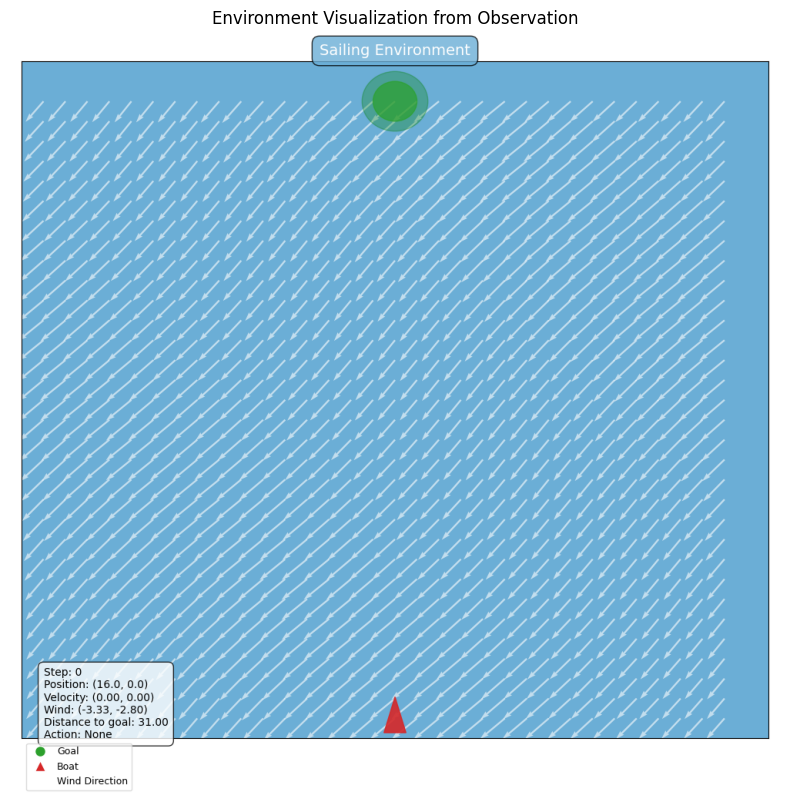

In [6]:
# Visualize the observation as an image
plt.figure(figsize=(10, 10))
img = SailingEnv.visualize_observation(observation)  # Call as a class method
plt.imshow(img)
plt.axis('off')
plt.title('Environment Visualization from Observation')
plt.show()

## 6. Rewards and Goal

Now let's understand how success is measured in the sailing environment.

### Reward Structure

The sailing environment provides rewards as follows:

- **Reaching the goal**: Large positive reward (100.0)
- **Other steps**: No reward (0.0)

This is a sparse reward structure, which makes the problem challenging. Your agent only receives feedback when it successfully reaches the goal.

### Discounted Reward

In reinforcement learning, we often use **discounted rewards** to emphasize immediate rewards over future ones. The discounted reward is calculated as:

$$R_{discounted} = \sum_{t=0}^{T} \gamma^t r_t$$

Where:
- $r_t$ is the reward at time step $t$
- $\gamma$ is the discount factor ($\gamma=0.99$ in our environment)
- $T$ is the total number of time steps

This means reaching the goal quickly results in a higher discounted reward than reaching it slowly.

### Episode Termination

An episode ends when:

1. The agent reaches the goal (success)
2. The maximum number of steps is reached (typically 200 steps)

Let's run a simple example to see the reward mechanism in action:

In [7]:
# Reset the environment
observation, info = env.reset(seed=42)

# Set up tracking
rewards = []
steps_to_goal = 0
discount_factor = 0.99  # The standard discount factor
reached_goal = False

# Manually move the boat toward the goal
print("Taking steps toward the goal...")
for step in range(1, 500):  # Increased to 500 steps to ensure we reach the goal
    # Always choose action 0 (North) for this demo
    action = 0  # Move North
    
    # Take a step
    observation, reward, terminated, truncated, info = env.step(action)
    
    # Track reward
    rewards.append(reward)
    
    # Report every 50 steps
    if step % 50 == 0:
        print(f"Step {step}: Position {info['position']}, Reward: {reward}")
    
    # Check if we're done
    if terminated and reward > 0:  # If terminated due to reaching the goal
        reached_goal = True
        steps_to_goal = step
        print(f"\nGoal reached at step {step}!")
        print(f"Final position: {info['position']}")
        print(f"Goal reward: {reward}")
        break
        
    if truncated:
        print(f"\nEpisode truncated at step {step} without reaching goal")
        break

# Calculate discounted reward
if reached_goal:
    # All rewards are 0 except the last one (which is 100)
    discounted_reward = 100 * (discount_factor ** (steps_to_goal - 1))
    
    print(f"\nDiscounted Reward Calculation:")
    print(f"- Raw goal reward: 100")
    print(f"- Discount factor: {discount_factor}")
    print(f"- Steps to goal: {steps_to_goal}")
    print(f"- Discounted reward: {discounted_reward:.2f}")
    
    # Show what would happen with different numbers of steps
    print("\nComparison of discounted rewards with different step counts:")
    for test_steps in [25, 50, 100, 150, 200]:
        test_reward = 100 * (discount_factor ** (test_steps - 1))
        print(f"- Reaching goal in {test_steps} steps: {test_reward:.2f}")
else:
    print("\nFailed to reach the goal in the allotted steps.")
    print("Discounted reward: 0.00")

Taking steps toward the goal...
Step 50: Position [16  6], Reward: 0.0
Step 100: Position [16 10], Reward: 0.0

Goal reached at step 118!
Final position: [16 30]
Goal reward: 100.0

Discounted Reward Calculation:
- Raw goal reward: 100
- Discount factor: 0.99
- Steps to goal: 118
- Discounted reward: 30.85

Comparison of discounted rewards with different step counts:
- Reaching goal in 25 steps: 78.57
- Reaching goal in 50 steps: 61.11
- Reaching goal in 100 steps: 36.97
- Reaching goal in 150 steps: 22.37
- Reaching goal in 200 steps: 13.53


## 7. Wind Scenarios

As mentioned earlier, the sailing challenge includes different wind conditions that your agent will need to handle. Let's load and visualize each of the training wind scenarios to understand their unique characteristics.

### Training Wind Scenarios

The training wind scenarios are designed to expose your agent to different starting wind patterns:

- Each wind scenario has a unique starting configuration (base direction, pattern scale, strength variation)
- All windfields evolve over time according to the same underlying dynamics
- Your agent must learn to adapt to both the initial conditions and how they change during an episode

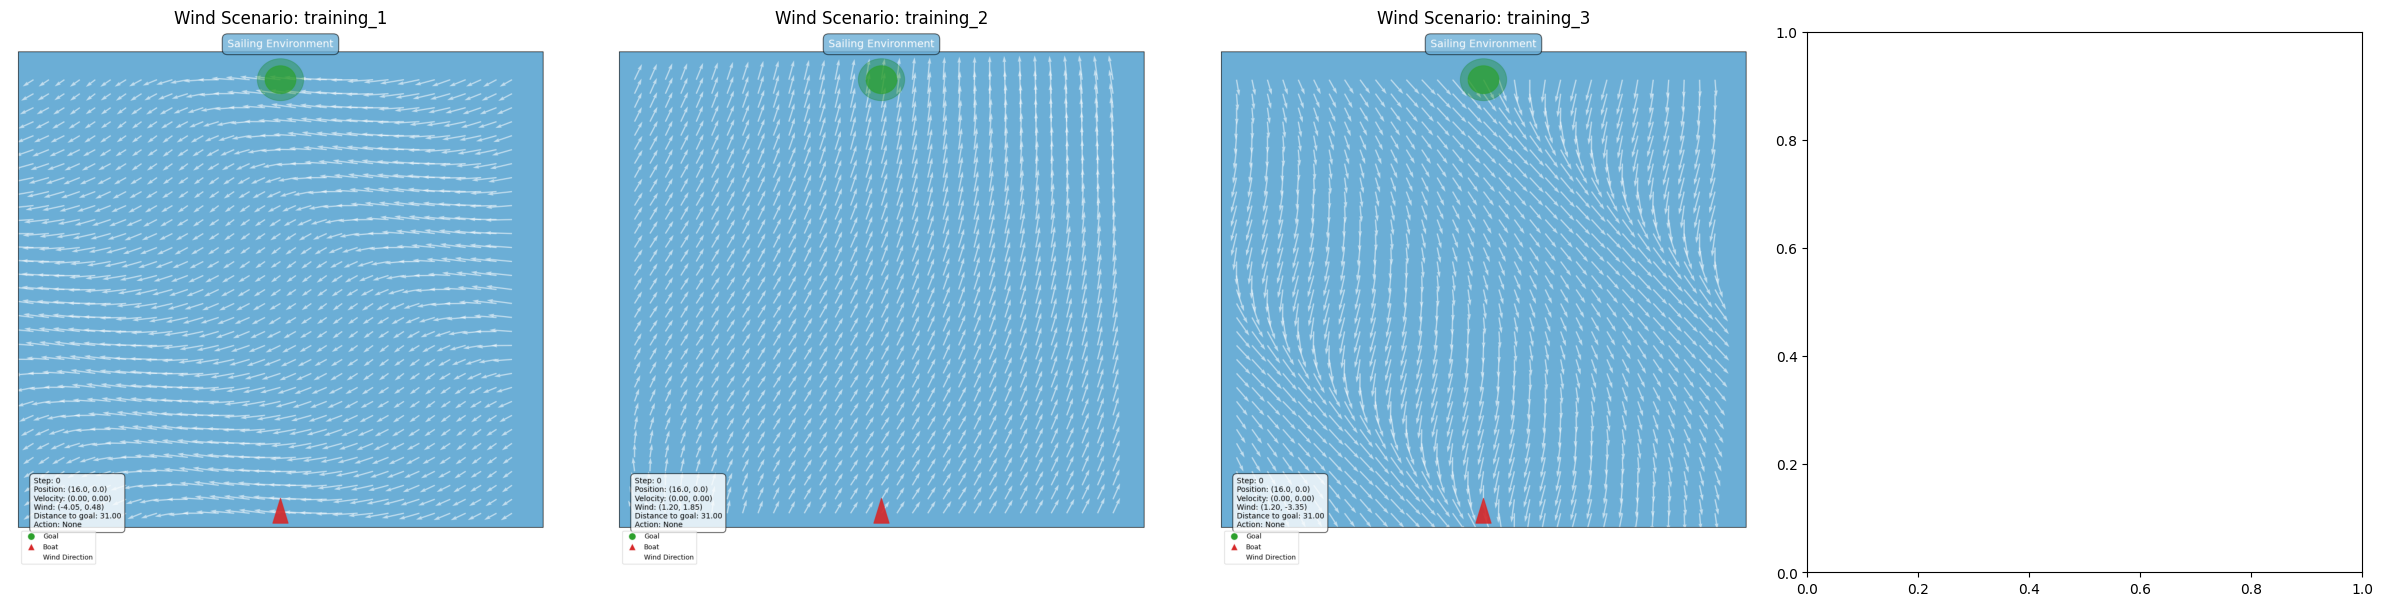


Training Wind Scenario 1: North-Northwest Wind
- Starting with North-Northwest wind direction

Training Wind Scenario 2: North-Northeast Wind
- Starting with North-Northeast wind direction

Training Wind Scenario 3: West Wind
- Starting with predominantly West wind direction

Test Wind Scenario: Hidden
- Not accessible during development
- Your agent will be evaluated on this initial condition
- Different starting configuration but evolves according to the same rules


In [8]:
# Load each wind scenario and visualize its wind pattern
wind_scenarios = {
    "training_1": get_wind_scenario("training_1"),
    "training_2": get_wind_scenario("training_2"),
    "training_3": get_wind_scenario("training_3")
}

# Add visualization parameters to each wind scenario
viz_params = {
    'env_params': {
        'wind_grid_density': 25,
        'wind_arrow_scale': 80,
        'render_mode': "rgb_array"
    }
}

# Create a figure for each wind scenario
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, (name, windfield) in enumerate(wind_scenarios.items()):
    # Create a copy with visualization parameters
    viz_windfield = windfield.copy()
    viz_windfield.update(viz_params)
    
    # Create environment with this wind scenario
    env = SailingEnv(
        wind_init_params=viz_windfield['wind_init_params'],
        wind_evol_params=viz_windfield['wind_evol_params'],
        wind_grid_density=25,
        wind_arrow_scale=80,
        render_mode="rgb_array"
    )
    
    # Reset and render
    env.reset(seed=42)
    
    # Display the image
    axes[i].imshow(env.render())
    axes[i].set_title(f"Wind Scenario: {name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print wind scenario descriptions
print("\nTraining Wind Scenario 1: North-Northwest Wind")
print("- Starting with North-Northwest wind direction")
print("\nTraining Wind Scenario 2: North-Northeast Wind")
print("- Starting with North-Northeast wind direction")
print("\nTraining Wind Scenario 3: West Wind")
print("- Starting with predominantly West wind direction")
print("\nTest Wind Scenario: Hidden")
print("- Not accessible during development")
print("- Your agent will be evaluated on this initial condition")
print("- Different starting configuration but evolves according to the same rules")

## 8. Wind Evolution

The wind doesn't remain static during an episode - it evolves over time according to common evolution parameters (which define an underlying common Markov Decision Process) shared by all wind scenarios. Let's visualize how wind changes over time in an wind scenario using an interactive slider:

> **Note**: For debugging purposes, there's a special `simple_static` wind scenario available through `get_wind_scenario("simple_static")` that maintains completely static wind conditions. This is an exception to the rule - all training and test wind scenarios evolve over time according to the same underlying dynamics, while this static version keeps wind constant to help with basic agent testing.

In [9]:
# Create an environment with the first training wind scenario
wind_scenario = get_wind_scenario("training_1")
wind_scenario.update(viz_params)

env = SailingEnv(
    wind_init_params=wind_scenario['wind_init_params'],
    wind_evol_params=wind_scenario['wind_evol_params'],
    wind_grid_density=25,
    wind_arrow_scale=80,
    render_mode="rgb_array"
)

# Reset the environment
env.reset(seed=42)

# Capture wind evolution over many steps for interactive visualization
wind_frames = []
for step in range(50):  # Capture 50 frames for smooth animation
    # Render current state
    frame = env.render()
    wind_frames.append(frame)
    
    # Take a "stay in place" action to let wind evolve
    env.step(8)  # Action 8 is "stay in place"

# Create interactive slider visualization
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def show_wind_evolution(step):
    """Display wind evolution at a specific step."""
    plt.figure(figsize=(10, 10))
    plt.imshow(wind_frames[step])
    plt.axis('off')
    plt.title(f'Wind Evolution - Step {step}')
    plt.show()

# Create interactive slider
interact(
    show_wind_evolution,
    step=IntSlider(
        min=0,
        max=len(wind_frames)-1,
        step=1,
        value=0,
        description='Step:',
        style={'description_width': 'initial'}
    )
)

print("Use the slider above to explore how the wind pattern changes over time!")
print("- Wind direction and strength evolve according to the common evolution parameters")
print("- This evolution is the same for all training and test wind scenarios")
print("- Your agent must adapt to these changing conditions while navigating")
print("- For debugging, you can use get_wind_scenario('simple_static') which has static wind")

interactive(children=(IntSlider(value=0, description='Step:', max=49, style=SliderStyle(description_width='ini…

Use the slider above to explore how the wind pattern changes over time!
- Wind direction and strength evolve according to the common evolution parameters
- This evolution is the same for all training and test wind scenarios
- Your agent must adapt to these changing conditions while navigating
- For debugging, you can use get_wind_scenario('simple_static') which has static wind


## 9. Conclusion and Next Steps

Congratulations! You now have a comprehensive understanding of the sailing environment:

✅ You understand the physics of sailing and how wind angle affects efficiency  
✅ You know the action space and how controls work  
✅ You understand the observation space and what information is available to your agent  
✅ You've seen how rewards are structured  
✅ You're familiar with the different wind scenarios and how they evolve over time  

### Next Steps

1. Move on to the next notebook to learn about creating and testing your agent
2. Experiment with different strategies for navigating in various wind conditions
3. Think about how to handle the "no-go zone" when sailing upwind
4. Consider how to optimize your path given the initial wind conditions and their evolution

Remember, the key challenge is creating an agent that can generalize across different wind scenarios, particularly the hidden test wind scenario. Your agent needs to adapt both to the starting wind configurations and how they change over time. Good luck with your sailing agent!